In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
import warnings
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox

# Time Series Modelling of S&P500 index

In [2]:
ticker = "^GSPC"
start_date = "2018-01-01"
end_date = pd.Timestamp.today().strftime('%Y-%m-%d')
sp500_data = yf.download(ticker, start=start_date, end=end_date)

# Calculate log returns of adjusted close price
sp500_data['Log_Return'] = np.log(sp500_data['Adj Close'] / sp500_data['Adj Close'].shift(1))
sp500_data.dropna(inplace=True)
sp500_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Log_Return
Date,,,,,,,
2018-01-03,2697.850098,2714.370117,2697.770020,2713.060059,2713.060059,3544030000,0.006378
2018-01-04,2719.310059,2729.290039,2719.070068,2723.989990,2723.989990,3697340000,0.004021
2018-01-05,2731.330078,2743.449951,2727.919922,2743.149902,2743.149902,3239280000,0.007009
2018-01-08,2742.669922,2748.510010,2737.600098,2747.709961,2747.709961,3246160000,0.001661
2018-01-09,2751.149902,2759.139893,2747.860107,2751.290039,2751.290039,3467460000,0.001302
...,...,...,...,...,...,...,...
2023-07-19,4563.870117,4578.430176,4557.479980,4565.720215,4565.720215,4115670000,0.002355
2023-07-20,4554.379883,4564.740234,4527.560059,4534.870117,4534.870117,3761770000,-0.006780
2023-07-21,4550.160156,4555.000000,4535.790039,4536.339844,4536.339844,3570190000,0.000324


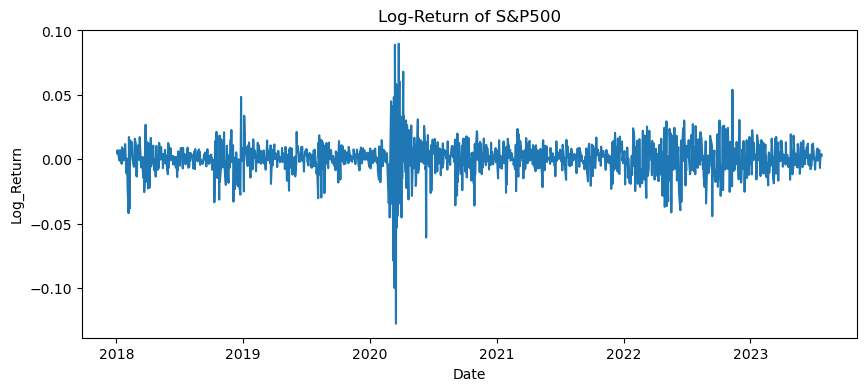

In [3]:
log_return = sp500_data['Log_Return']
plt.figure(figsize=(10,4))
plt.plot(log_return)
plt.xlabel('Date')
plt.ylabel('Log_Return')
plt.title('Log-Return of S&P500')
plt.show()

##
ARIMA Fit: Order chosen by minimizing AIC

final ARIMA order chosen: (4, 0, 5)


<Figure size 1000x400 with 0 Axes>

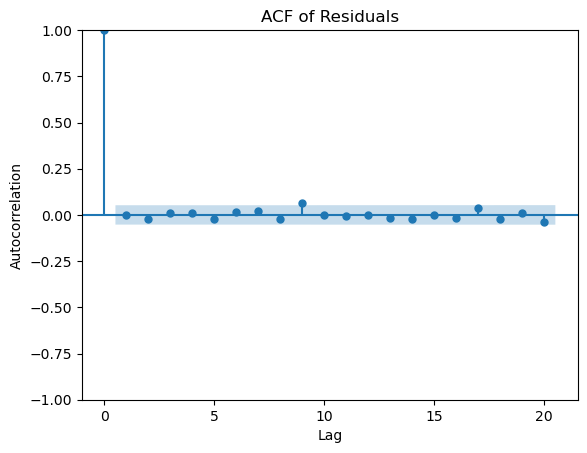

<Figure size 1000x400 with 0 Axes>

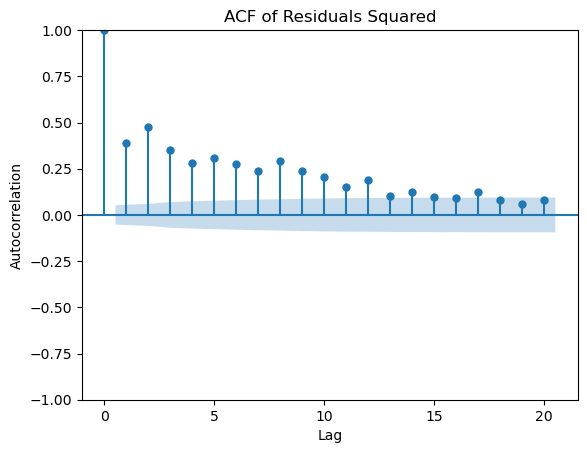

In [9]:
warnings.filterwarnings("ignore")
final_aic = float('inf')
final_order = (0,0,0)
for p in range(6):
    for d in range(3):
        for q in range(6):
            if p==0 and q==0:
                continue
            try:
                # Fit ARIMA model
                model_fit = ARIMA(log_return, order=(p,d,q)).fit()
            except:
                continue

            current_aic = model_fit.aic
            if current_aic<final_aic:
                final_aic = current_aic
                final_order = (p,d,q)
                final_arima = model_fit

print(f'final ARIMA order chosen: {final_order}')
residuals = final_arima.resid
plt.figure(figsize=(10, 4))
plot_acf(residuals, lags=20, alpha=0.05)
plt.title(f'ACF of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

residual2 = np.square(residuals)
plt.figure(figsize=(10, 4))
plot_acf(residual2, lags=20, alpha=0.05)
plt.title(f'ACF of Residuals Squared')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()                

LJUNG-BOX Test on Residuals to check if it is White Noise

In [11]:
box_test_result  = acorr_ljungbox(residuals,lags=20,return_df=True)
print(box_test_result[-3:])
if box_test_result.iloc[-1]['lb_pvalue']>0.05:
    print('Residuals are white noise with 95% confidence')

      lb_stat  lb_pvalue
18  13.440430   0.764773
19  13.677448   0.802159
20  15.896737   0.723010
Residuals are white noise with 95% confidence


### ARIMA Prediction(in-sample) prediction on time horizons

In [20]:
start = '2019-02-01'
end = '2019-04-30'
arima_prediction = final_arima.predict(start=start,end=end)
print(arima_prediction)

Date
2019-02-01    0.002618
2019-02-04   -0.001208
2019-02-05    0.001164
2019-02-06   -0.001581
2019-02-07    0.001677
                ...   
2019-04-24    0.001267
2019-04-25   -0.000133
2019-04-26    0.001789
2019-04-29   -0.001864
2019-04-30    0.001699
Name: predicted_mean, Length: 61, dtype: float64


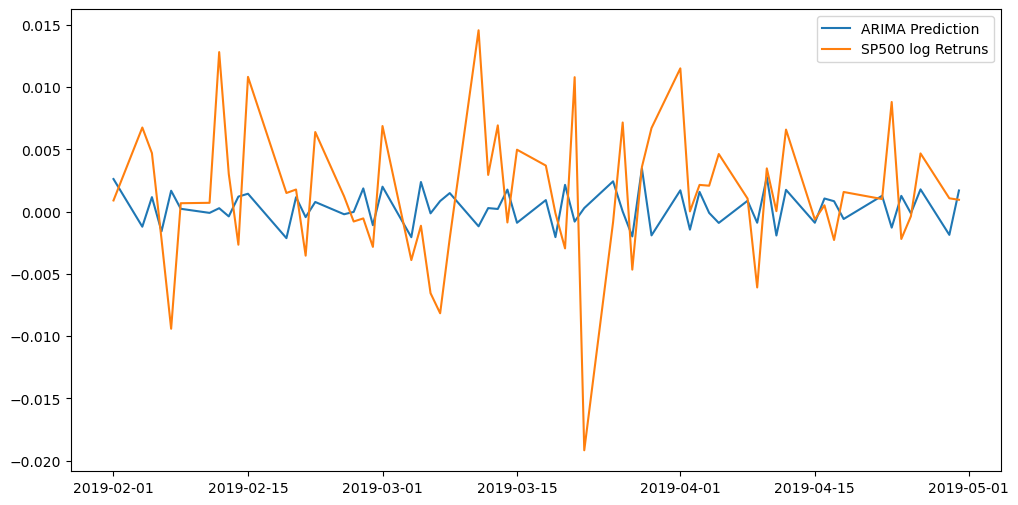

In [21]:
data = log_return.loc['2019-02-01':'2019-04-30']
plt.figure(figsize=(12,6))
plt.plot(arima_prediction,label='ARIMA Prediction')
plt.plot(data,label='SP500 log Retruns')
plt.legend()
plt.show()

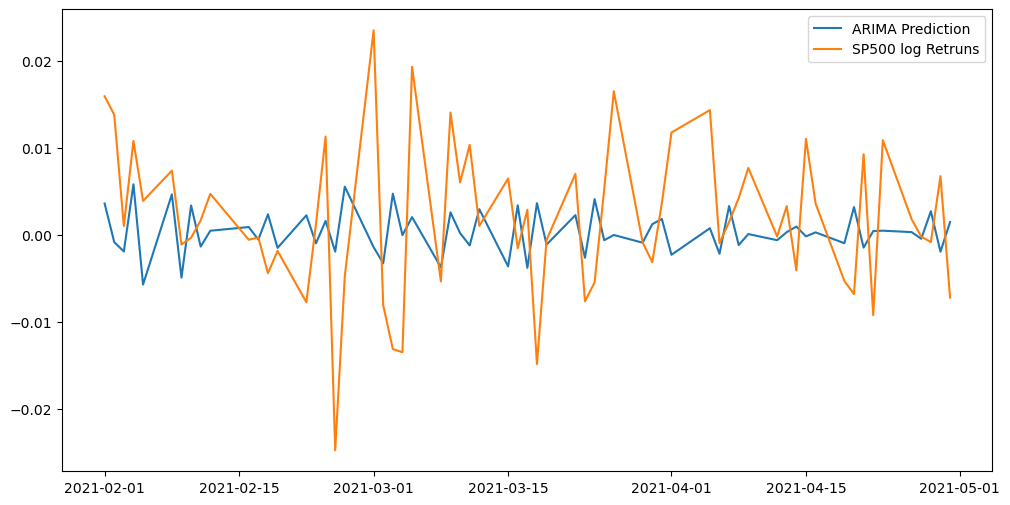

In [23]:
start = '2021-02-01'
end = '2021-04-30'
arima_prediction_2021 = final_arima.predict(start=start,end=end)
data_2021 = log_return.loc[start:end]
plt.figure(figsize=(12,6))
plt.plot(arima_prediction_2021,label='ARIMA Prediction')
plt.plot(data_2021,label='SP500 log Retruns')
plt.legend()
plt.show()

 Observation: The direction of predicted returns(In-Sample) seems good enough. But needs to account for volatility clustering

## FIT GARCH on Residuals of ARIMA model
It will allow us to capture the volatility and improve our model

### GARCH with 'Constant' Mean Model

In [78]:
vol_forecast = []
residual_forecast = []
test = 252
for i in range(test):
    train = residuals.iloc[i:-test+i]
    #AIC based model selection
    vol_aic = float('inf')
    vol_order = (0,0)
    for p_garch in range(5):
        for q_garch in range(5):
            if p==0 and q==0:
                continue
            try:
                vol_model = arch_model(train,mean='Constant',vol='GARCH',p=p_garch,q=q_garch).fit(disp='off',show_warning=False)
            except:
                continue    
            if vol_model.aic<vol_aic:
                vol_aic = vol_model.aic
                final_vol_model = vol_model
                vol_order = (p_garch,q_garch)
    f = final_vol_model.forecast(horizon=1)
    vol_forecast.append(np.sqrt(f.variance['h.1'].iloc[-1]))
    residual_forecast.append(vol_forecast[i]*np.random.standard_normal()+f.mean['h.1'].iloc[-1])  


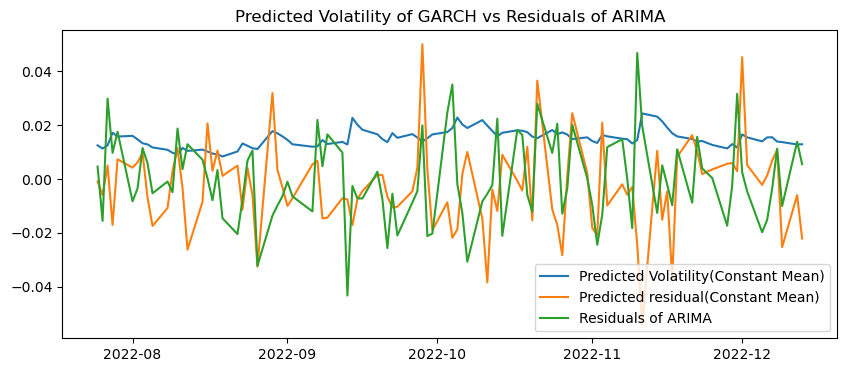

In [79]:
vol_forecast_series = pd.Series(vol_forecast,index=residuals.index[-test:])
residual_forecast_series = pd.Series(residual_forecast,index= residuals.index[-test:])
plt.figure(figsize=(10,4))
plt.plot(vol_forecast_series[:100],label='Predicted Volatility(Constant Mean)')
plt.plot(residual_forecast_series[:100],label='Predicted residual(Constant Mean)')
plt.plot(residuals.iloc[-test:-test+100],label='Residuals of ARIMA')
plt.legend()
plt.title('Predicted Volatility of GARCH vs Residuals of ARIMA')
plt.show()

RMSE of GARCH with 'Constant' mean model is 0.017503860692308776


<Figure size 1000x400 with 0 Axes>

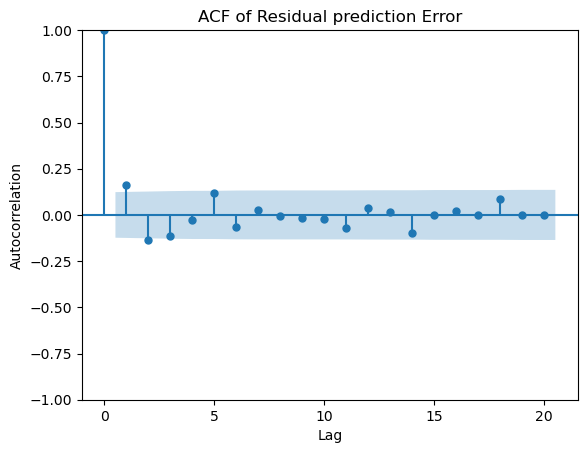

<Figure size 1000x400 with 0 Axes>

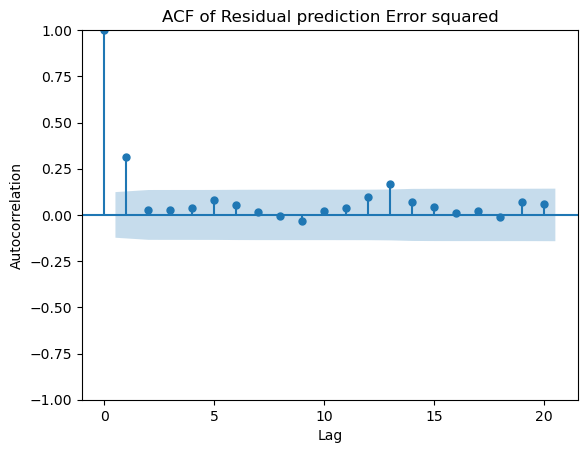

In [80]:
residual_prediction_error = residual_forecast_series - residuals.iloc[-test:]
rmse = np.sqrt(np.square(residual_prediction_error).mean())
print(f"RMSE of GARCH with 'Constant' mean model is {rmse}")
plt.figure(figsize=(10, 4))
plot_acf(residual_prediction_error, lags=20, alpha=0.05)
plt.title(f'ACF of Residual prediction Error')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

plt.figure(figsize=(10, 4))
plot_acf(np.square(residual_prediction_error), lags=20, alpha=0.05)
plt.title(f'ACF of Residual prediction Error squared')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

### GARCH with Zero mean model

In [75]:
vol_forecast = []
residual_forecast = []
test = 252
for i in range(test):
    train = residuals.iloc[i:-test+i]
    #AIC based model selection
    vol_aic = float('inf')
    vol_order = (0,0)
    for p_garch in range(5):
        for q_garch in range(5):
            if p==0 and q==0:
                continue
            try:
                vol_model = arch_model(train,mean='Zero',vol='GARCH',p=p_garch,q=q_garch).fit(disp='off',show_warning=False)
            except:
                continue    
            if vol_model.aic<vol_aic:
                vol_aic = vol_model.aic
                final_vol_model = vol_model
                vol_order = (p_garch,q_garch)
    f = final_vol_model.forecast(horizon=1)
    vol_forecast.append(np.sqrt(f.variance['h.1'].iloc[-1]))
    residual_forecast.append(vol_forecast[i]*np.random.standard_normal())       

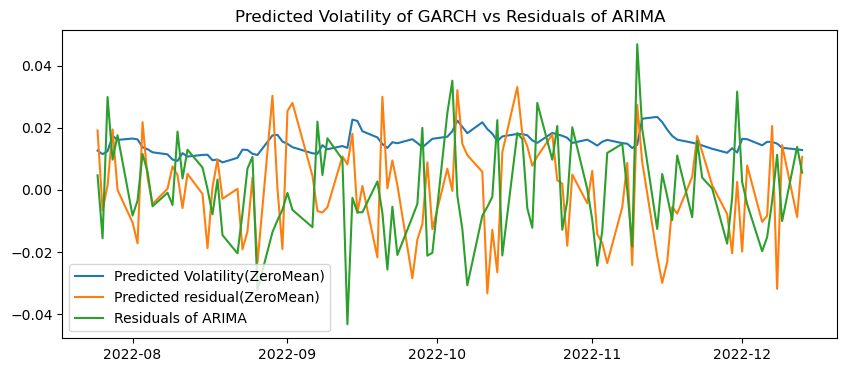

In [76]:
vol_forecast_series = pd.Series(vol_forecast,index=residuals.index[-test:])
residual_forecast_series = pd.Series(residual_forecast,index= residuals.index[-test:])
plt.figure(figsize=(10,4))
plt.plot(vol_forecast_series[:100],label='Predicted Volatility(ZeroMean)')
plt.plot(residual_forecast_series[:100],label='Predicted residual(ZeroMean)')
plt.plot(residuals.iloc[-test:-test+100],label='Residuals of ARIMA')
plt.legend()
plt.title('Predicted Volatility of GARCH vs Residuals of ARIMA')
plt.show()

RMSE of GARCH with 'Zero' mean model is 0.016154970939979155


<Figure size 1000x400 with 0 Axes>

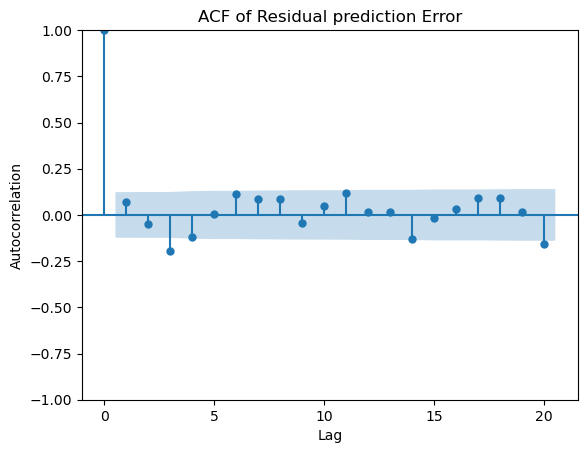

<Figure size 1000x400 with 0 Axes>

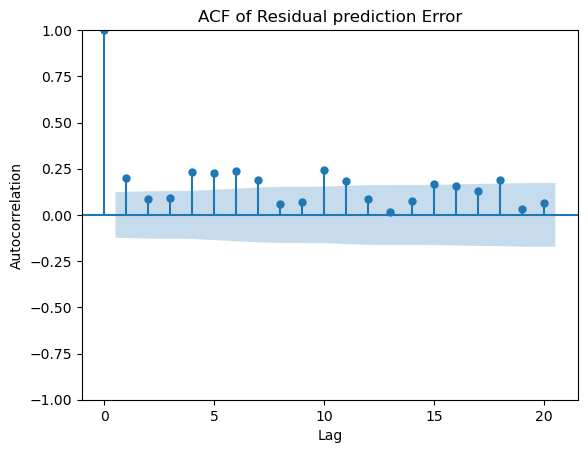

In [77]:
residual_prediction_error = residual_forecast_series - residuals.iloc[-test:]
rmse = np.sqrt(np.square(residual_prediction_error).mean())
print(f"RMSE of GARCH with 'Zero' mean model is {rmse}")
plt.figure(figsize=(10, 4))
plot_acf(residual_prediction_error, lags=20, alpha=0.05)
plt.title(f'ACF of Residual prediction Error')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

plt.figure(figsize=(10, 4))
plot_acf(np.square(residual_prediction_error), lags=20, alpha=0.05)
plt.title(f'ACF of Residual prediction Error')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

So, we see that much of the serial corelation of Variance of residuals have been resolved. But can be made better

## ARIMA+GARCH Rolling Out-of-sample prediction of returns

In [4]:
warnings.filterwarnings("ignore")
predicton = []
fail = {}
test = 30
for i in range(test):
    train = log_return.iloc[i:-test+i]
    #AIC Based ARIMA model selection
    final_aic = float('inf')
    for p in range(6):
        for d in range(3):
            for q in range(6):
                if p==0 and q==0:
                    continue
                try:
                    # Fit ARIMA model
                    model_fit = ARIMA(train, order=(p,d,q)).fit()
                except:
                    continue

                current_aic = model_fit.aic
                if current_aic<final_aic:
                    final_aic = current_aic
                    final_arima = model_fit
    residuals = final_arima.resid
    box_test_result  = acorr_ljungbox(residuals,lags=20,return_df=True)
    if box_test_result.iloc[-1]['lb_pvalue']>0.05:
        #AIC based GARCH Model Selection and fitting:
        vol_aic = float('inf')
        for p_garch in range(5):
            for q_garch in range(5):
                if p==0 and q==0:
                    continue
                try:
                    vol_model = arch_model(residuals,mean='Zero',vol='GARCH',p=p_garch,q=q_garch).fit(disp='off',show_warning=False)
                except:
                    continue    
                if vol_model.aic<vol_aic:
                    vol_aic = vol_model.aic
                    final_vol_model = vol_model
        #Prediction with arima+garch
        predicted_mu = final_arima.forecast(steps=1).iloc[0]
        garch_forecast = final_vol_model.forecast(horizon=1)
        predicted_et = np.sqrt(garch_forecast.variance['h.1'].iloc[-1])*np.random.standard_normal()
        final_prediction = predicted_mu+predicted_et
        predicton.append(final_prediction)
    else:
        print(f'could not fit ARIMA on {log_return.index[i+test]}')
        fail[log_return.index[i+test]] = 1



In [10]:
#For ARIMA prediction only
start = '2023-06-12'
end = '2023-07-25'
arima_prediction = final_arima.predict(start=start,end=end)


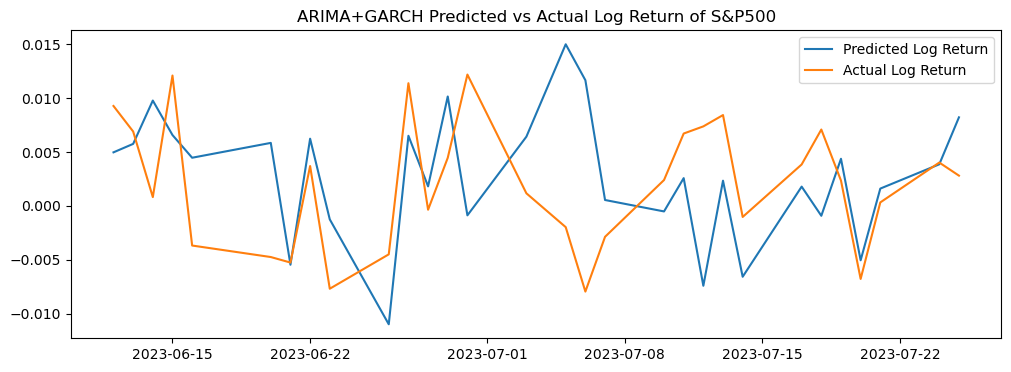

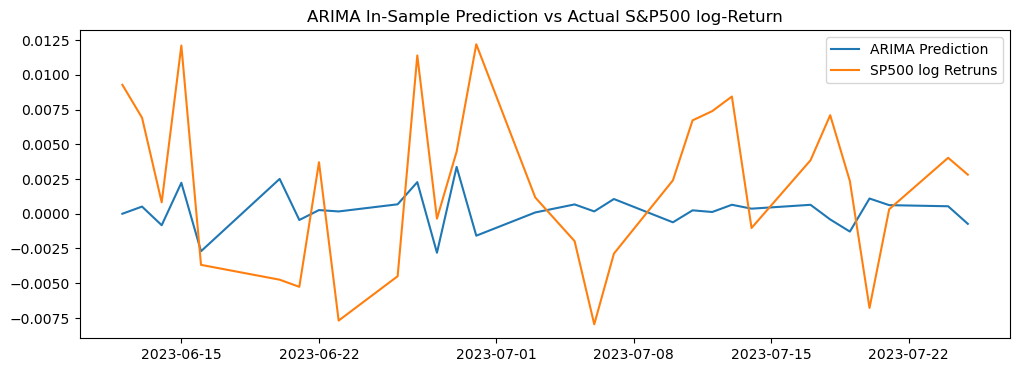

In [12]:
forecast_series = pd.Series(predicton,index= log_return.index[-test:])
plt.figure(figsize=(12,4))
plt.plot(forecast_series,label='Predicted Log Return')
plt.plot(log_return.iloc[-test:],label='Actual Log Return')
plt.legend()
plt.title('ARIMA+GARCH Predicted vs Actual Log Return of S&P500')
plt.show()

data = log_return.loc[start:end]
plt.figure(figsize=(12,4))
plt.plot(arima_prediction,label='ARIMA Prediction')
plt.plot(data,label='SP500 log Retruns')
plt.title("ARIMA In-Sample Prediction vs Actual S&P500 log-Return")
plt.legend()
plt.show()

In [13]:
prediction_error = forecast_series - log_return.iloc[-test:]
rmse = np.sqrt((np.square(prediction_error)).mean())
print(f'RMSE of the ARIMA+GARCH model: {rmse}')

RMSE of the ARIMA+GARCH model: 0.007665962205157534


### Conclusion: 
ARIMA+GARCH model does well in predicting direction of log-return of S&P500 index. But needs to be improved by improved models to account for shocks and market volatilty more aptly


### Further Suggestions:
i)Should backtest on this model.
 
ii) Should perform similar analysis on larger set of assets

iii) Should be inspecting for possible model improvements. At first, trying variations of ARIMA and GARCH family of models